<a href="https://colab.research.google.com/github/effection00/projects/blob/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%201.%20ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 357 kB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/train.csv")
age_gender = pd.read_csv("/content/drive/MyDrive/age_gender_info.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")


In [68]:
df.shape

(2952, 15)

In [69]:
train = df

# 전처리 

In [5]:
# 타겟 분리

In [70]:
# 데이터 중복제거
train.drop_duplicates(inplace=True)

In [71]:
train.shape

(2632, 15)

## 특이값 처리

In [72]:
train[train['임대보증금']=='-']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2547,C1326,1934,아파트,부산광역시,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2548,C1326,1934,아파트,부산광역시,국민임대,24.79,104,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2549,C1326,1934,아파트,부산광역시,국민임대,26.83,590,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2550,C1326,1934,아파트,부산광역시,국민임대,37.70,464,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2551,C1326,1934,아파트,부산광역시,국민임대,46.94,304,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2680,C1786,480,아파트,강원도,행복주택,16.91,156,25.0,K,-,-,0.0,3.0,338.0,345.0
2681,C1786,480,아파트,강원도,행복주택,26.90,136,25.0,K,-,-,0.0,3.0,338.0,345.0
2682,C1786,480,아파트,강원도,행복주택,26.90,72,25.0,K,-,-,0.0,3.0,338.0,345.0
2683,C1786,480,아파트,강원도,행복주택,26.90,24,25.0,K,-,-,0.0,3.0,338.0,345.0
2906,C2186,924,아파트,대구광역시,국민임대,29.17,238,0.0,H,-,-,0.0,8.0,664.0,744.0


In [73]:
# 특이문자 "ㅡ" 존재 => 0으로 대체
train.loc[train['임대보증금']=='-','임대보증금'] = 0
train['임대보증금']=pd.to_numeric(train['임대보증금'])

In [74]:
test.loc[test['임대보증금']=='-','임대보증금'] = 0
test['임대보증금']=pd.to_numeric(test['임대보증금'])

In [75]:
# 임대보증금과 동일하게 처리
train.loc[train['임대료']=='-','임대료'] = 0
train['임대료']=pd.to_numeric(train['임대료'])

In [76]:
test.loc[test['임대료']=='-','임대료'] = 0
test['임대료']=pd.to_numeric(test['임대료'])

In [17]:
# 그래프 한글처리
import matplotlib.pyplot
import matplotlib as mpl

mpl.pyplot.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus']=False

## 결측값 처리

In [77]:
df.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           292
임대료                             292
도보 10분거리 내 지하철역 수(환승노선 수 반영)    155
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

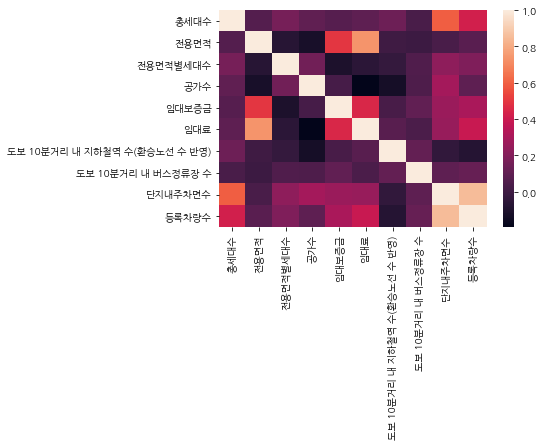

In [78]:
import seaborn as sns
sns.heatmap(train.corr()) 

# 전용면적은 임대료와 임대보증금과 연관 관계가 깊다 -> 전용면접에 따라 결측치 처리
# 타겟값은 단지내 주차면수와 큰 관련이 있다는 것을 알 수 있음

In [20]:
train['전용면적'].describe()

count    2632.000000
mean       46.091303
std        32.559242
min        12.620000
25%        36.500000
50%        46.405000
75%        51.850000
max       583.400000
Name: 전용면적, dtype: float64

## 임대보증금, 임대료 결측치
### 전용면적 범주화 후 결측치 채우기 

In [79]:
bins = [0,12,36,46,51,584]
label = [0,1,2,3,4]
train['전용면적범주화'] = pd.cut(train['전용면적'],bins,right=False , labels= label)

bins = [0,12,36,46,51,584]
label = [0,1,2,3,4]
test['전용면적범주화'] = pd.cut(test['전용면적'],bins,right=False , labels= label)

In [80]:
# 전용면적 범주가 같은 단지코드의 임대보증금의 중앙값과 임대료의 중앙값을 넣어줌
train['임대보증금'].fillna(train.groupby('전용면적범주화')['임대보증금'].transform('median'),inplace=True)
train['임대료'].fillna(train.groupby('전용면적범주화')['임대료'].transform('median'),inplace=True)

test['임대보증금'].fillna(test.groupby('전용면적범주화')['임대보증금'].transform('median'),inplace=True)
test['임대료'].fillna(test.groupby('전용면적범주화')['임대료'].transform('median'),inplace=True)


## 도보 10분내 지하철역 수 , 도보 10분거리 내 지하철역 수

In [81]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts()

0.0    2130
1.0     308
2.0      33
3.0       6
Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64

In [82]:
# 0이 대부분이므로 결측치 최빈값으로 넣어줌
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
train['도보 10분거리 내 버스정류장 수']=train['도보 10분거리 내 버스정류장 수'].fillna(0)

test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
test['도보 10분거리 내 버스정류장 수']=train['도보 10분거리 내 버스정류장 수'].fillna(0)

In [83]:
train = train.drop(['전용면적범주화'],axis=1)
test = test.drop(['전용면적범주화'],axis=1)

# EDA

In [84]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [64]:
len(train['단지코드'].unique())

423

In [65]:
len(train)

2632

In [94]:
new = pd.DataFrame(train.groupby(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '공가수',
       '자격유형', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수','등록차량수'])['임대보증금','임대료','전용면적별세대수','전용면적'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
round(new.head(),0)
# 단지코드 내의 건물들은 임대보증금, 임대료, 전용면적별세대수, 전용면적 특성외에는 큰 차이가 없는 것으로 보인다 => 등록챠랑수도 이를 기반으로 구할 수 있을 것으로 보임 

임대보증금  ...  전용면적
단지코드  총세대수 임대건물구분 지역    공급유형 공가수  자격유형 도보 10분거리 내 지하철역 수(환승노선 수 반영) 도보 10분거리 내 버스정류장 수 단지내주차면수 등록차량수               ...      
C1000 566  아파트    충청북도  국민임대 10.0 A    0.0                          1.0                438.0   481.0   13203571.0  ...  45.0
C1004 521  상가     충청남도  임대상가 3.0  D    0.0                          2.0                153.0   93.0    14522231.0  ...  44.0
           아파트    충청남도  영구임대 3.0  C    0.0                          2.0                153.0   93.0     4705000.0  ...  39.0
C1005 1144 아파트    충청남도  국민임대 16.0 A    0.0                          8.0                950.0   376.0   17107667.0  ...  54.0
C1013 1308 아파트    광주광역시 국민임대 16.0 A    0.0                          6.0                1119.0  1665.0  24924800.0  ...  46.0

[5 rows x 4 columns]

# 타겟값 분리 

In [98]:
target = train['등록차량수']
train = train.drop(['등록차량수'],axis=1)

### 범주형 변수 원핫인코딩

In [99]:
from category_encoders import OneHotEncoder

onehot = OneHotEncoder(cols=['단지코드','임대건물구분','지역','공급유형','자격유형'])
train = onehot.fit_transform(train)
test = onehot.transform(test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##이상치탐지

In [ ]:
#이상치 탐지 isolationForest 이용
from sklearn.ensemble import IsolationForest
import collections

clf = IsolationForest(n_estimators=100,
                      max_samples="auto", 
                      contamination=0.1,
                      max_features=1,
                      bootstrap=False,
                      n_jobs=1,
                      random_state=None,
                      verbose=0)

clf.fit(train[['총세대수','전용면적','전용면적별세대수','공가수','임대보증금','임대료','단지내주차면수']])
outlier  = clf.predict(train[['총세대수','전용면적','전용면적별세대수','공가수','임대보증금','임대료','단지내주차면수']])
# 이상치 개수 세기
collections.Counter(outlier)

train['out'] = outlier 
out_index = train.loc[train['out']==-1].index
train = train.drop(out_index, axis=0)

In [ ]:
outlier  = clf.predict(train[['총세대수','전용면적','전용면적별세대수','공가수','임대보증금','임대료','단지내주차면수']])
# 이상치 개수 세기
collections.Counter(outlier)

train['out'] = outlier 
out_index = train.loc[train['out']==-1].index
train = train.drop(out_index, axis=0)

,단지코드_1,단지코드_2,단지코드_3,단지코드_4,단지코드_5,단지코드_6,단지코드_7,단지코드_8,단지코드_9,단지코드_10,단지코드_11,단지코드_12,단지코드_13,단지코드_14,단지코드_15,단지코드_16,단지코드_17,단지코드_18,단지코드_19,단지코드_20,단지코드_21,단지코드_22,단지코드_23,단지코드_24,단지코드_25,단지코드_26,단지코드_27,단지코드_28,단지코드_29,단지코드_30,단지코드_31,단지코드_32,단지코드_33,단지코드_34,단지코드_35,단지코드_36,단지코드_37,단지코드_38,단지코드_39,단지코드_40,...,지역_11,지역_12,지역_13,지역_14,지역_15,지역_16,공급유형_1,공급유형_2,공급유형_3,공급유형_4,공급유형_5,공급유형_6,공급유형_7,공급유형_8,공급유형_9,공급유형_10,전용면적,전용면적별세대수,공가수,자격유형_1,자격유형_2,자격유형_3,자격유형_4,자격유형_5,자격유형_6,자격유형_7,자격유형_8,자격유형_9,자격유형_10,자격유형_11,자격유형_12,자격유형_13,자격유형_14,자격유형_15,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,out
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,39.72,134,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15667000.0,103680.0,0.0,3.0,1425.0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,39.72,15,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15667000.0,103680.0,0.0,3.0,1425.0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51.93,385,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27304000.0,184330.0,0.0,3.0,1425.0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51.93,15,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27304000.0,184330.0,0.0,3.0,1425.0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51.93,41,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27304000.0,184330.0,0.0,3.0,1425.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,49.20,19,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11346000.0,116090.0,0.0,1.0,166.0,1
2948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51.08,34,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14005000.0,142310.0,0.0,1.0,166.0,1
2949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51.73,34,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14005000.0,142310.0,0.0,1.0,166.0,1
2950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51.96,114,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14005000.0,142310.0,0.0,1.0,166.0,1


In [ ]:
test.isnull.sum()

NameError: ignored